Данный файл написан для построения вариантов моделей атрибуции, а также анализа их применимости и возможности построения. Будут рассмотрены следующие варианты моделей:
1. по последнему касанию
2. по первому касанию
3. 40-20-40
4. линейная

In [221]:
import pandas as pd

In [222]:
aggregation = pd.read_excel('aggregation.xlsx')

In [223]:
aggregation.head()

,Unnamed: 0,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
0,0,cc9450e76fd7a6b5e8f5bd14c0a9a4f1,loan,app,2023-06-15 21:20:43.703,click,2023-06-15 21:20:43.703,NaN,ios / mobile_app,brandkeys_light_mind,2023-06-02 07:54:25.593,2023-06-02 07:54:25.593,click,0.0,0.0
1,1,ba680bab37704cf1bff4c180bda7c31a,deposits,app,2023-02-19 05:22:29.299,show,2023-02-19 05:22:29.299,NaN,ru.android.bankproduct / mobile_app,title_target_market,2023-02-02 14:50:32.571,2023-02-02 14:50:32.571,show,NaN,NaN
2,2,6b2c800a06aaa250309e2028c5613ae2,loan,web,2023-05-23 07:14:19.645,show,2023-05-23 07:14:19.645,NaN,yandex / cpc,megamaket_target_reels,2023-05-13 06:43:56.328,2023-05-13 06:43:56.328,show,NaN,NaN
3,3,24e703a14dec52207ab4f41567ad0ea8,loan,web,2023-11-08 07:43:50.838,show,2023-11-08 07:43:50.838,NaN,yandex / cpc,rebrand_adv_market,2023-10-27 11:00:11.871,2023-10-27 11:00:11.871,show,NaN,NaN
4,4,87f8a9bcff77b3546bda9e13edccc995,deposits,app,2023-08-25 01:48:00.178,show,2023-08-25 01:48:00.178,NaN,ru.android.bankproduct / mobile_app,case_target_title,2023-08-20 20:41:04.555,2023-08-20 20:41:04.555,show,NaN,NaN


Строим модель атрибуции по последнему касанию. В рамках модели атрибуции по последнему касанию мы присваеваем баллы только конверсионным действиям:

In [224]:
# Фильтрация данных по конверсиям
conversions = aggregation[aggregation['event_status'] == 'sale']

# Группировка данных по каналу source_medium и рекламной кампании utm_campaign
attribution_model = conversions.groupby(['source_medium']).agg(
    conversions=('event_status', 'count'),
    avg_payout=('payout', 'mean'),
    min_payout=('payout', 'min'),
    max_payout=('payout', 'max'),
    sum_payout=('payout', 'sum'),
    avg_campaign_cost=('campaign_cost', 'mean')
).reset_index()

# Получение первых 10 записей по количеству конверсий
top_conversions = attribution_model.nlargest(10, 'sum_payout')

In [ ]:
top_conversions

Строим график, отражающий результат агрегации

C:\Users\БОСС\AppData\Local\Temp\ipykernel_14620\1935828860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversions['event_status'] = 1


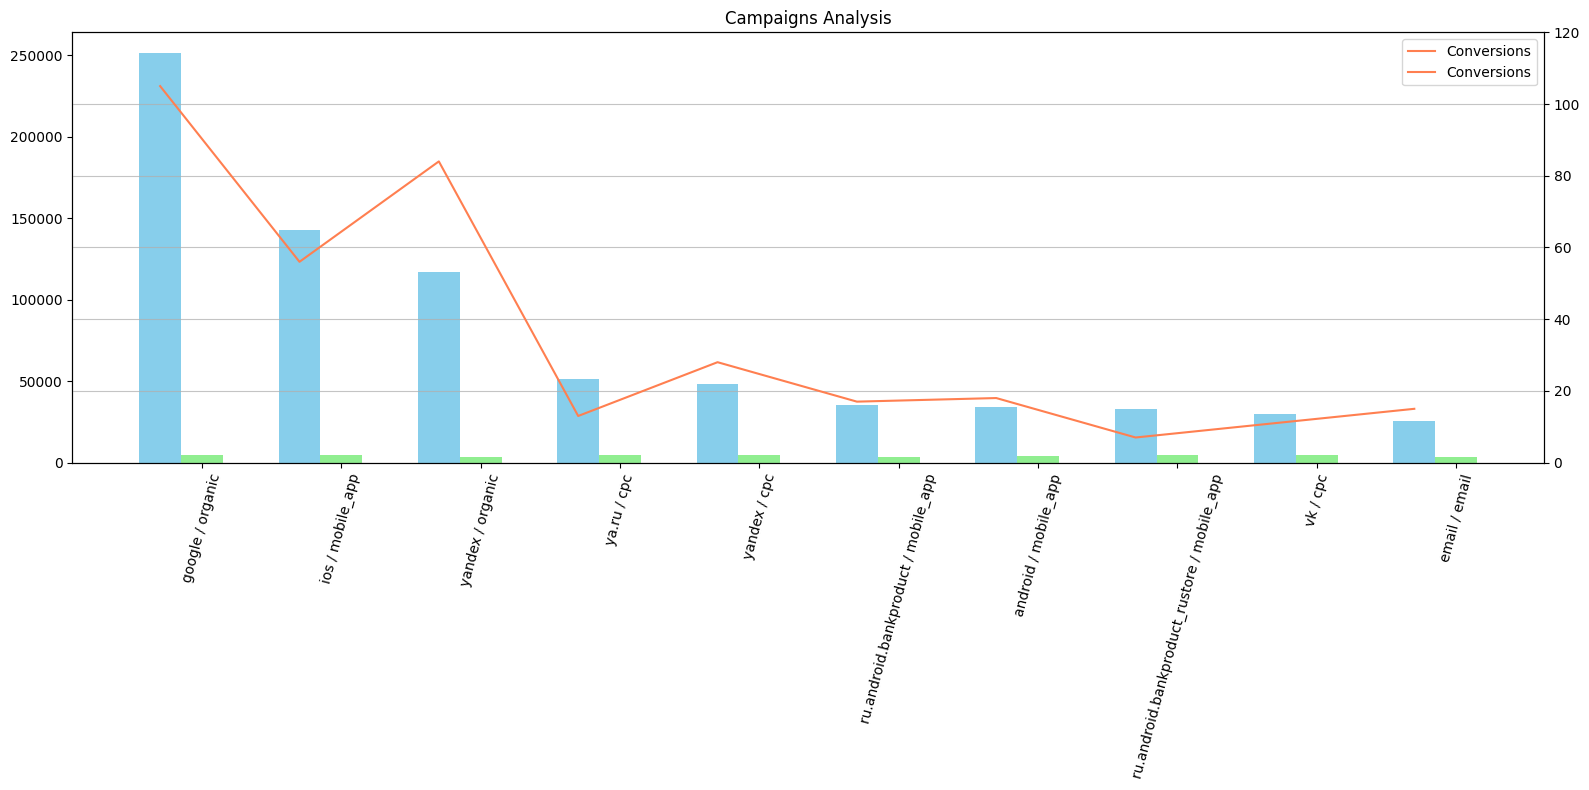

In [225]:
import matplotlib.pyplot as plt

conversions['event_status'] = 1

# Группировка данных по кампаниям, средней выплате и количеству конверсий
campaigns_data = conversions.groupby('source_medium').agg(
    avg_payout=('payout', 'mean'),
    conversions=('event_status', 'sum'),
    sum_payout=('payout', 'sum'),
    # avg_cost=('campaign_cost', 'mean')
).sort_values(by='sum_payout', ascending=False).head(10)

# Построение гистограммы для топ 10 кампаний
plt.figure(figsize=(16, 8))

bar_width = 0.3
index = range(len(campaigns_data))

# Первая система координат для гистограммы
ax1 = plt.gca()
ax2 = ax1.twinx()

plt.ylim(0,120)

ax1.bar(index, campaigns_data['sum_payout'], bar_width, label='Sum Payout', color='skyblue')
ax1.bar([i + bar_width for i in index], campaigns_data['avg_payout'], bar_width, label='Avg Payout', color='lightgreen')
# ax1.bar([i + 2*bar_width for i in index], campaigns_data['avg_cost'], bar_width, label='Avg Cost', color='blue')
ax2.plot(index, campaigns_data['conversions'], bar_width, label='Conversions', color='coral')

# Rotating X-axis labels
for tick in ax1.get_xticklabels():
    tick.set_rotation(75)
for tick in ax2.get_xticklabels():
    tick.set_rotation(75)
    
plt.xlabel('Campaigns')
plt.title('Campaigns Analysis')
plt.xticks([i + bar_width for i in index], campaigns_data.index, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()


plt.show()

Анализируем возможность построения модели атрибуции по первому касанию

In [226]:
# Преобразование столбца "event_dtm" в формат datetime
aggregation['event_dtm'] = pd.to_datetime(aggregation['event_dtm'])

# Сортировка датафрейма по столбцу "event_dtm" от старых дат к новым
aggregation = aggregation.sort_values(by='event_dtm')

In [227]:
# смотрим возможность импользования модели по первому касанию на примере одного клиента
df_first_touch = aggregation[aggregation['user_id'] == 'f348c115a480ada037123c6d87341c8f']
df_first_touch.head()

,Unnamed: 0,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
3684,4136,f348c115a480ada037123c6d87341c8f,loan,app,2023-04-01 00:30:47.539,conversion,2023-04-01 00:30:47.539,sale,yandex / organic,title_reels_reels,2023-03-19 06:11:43.769,2023-03-19 06:11:43.769,conversion,59.2,NaN
3682,4132,f348c115a480ada037123c6d87341c8f,loan,app,2023-04-01 00:30:47.539,show,2023-04-01 00:30:47.539,NaN,ios / mobile_app,rebrand_mind_target,2023-03-18 22:32:58.435,2023-03-18 22:32:58.435,show,NaN,NaN
3683,4133,f348c115a480ada037123c6d87341c8f,loan,app,2023-04-01 00:30:47.539,click,2023-04-01 00:30:47.539,NaN,yandex / cpc,reels_light_target,2023-03-11 22:36:26.264,2023-03-11 22:36:26.264,click,0.0,236.57
3686,4138,f348c115a480ada037123c6d87341c8f,loan,web,2023-04-01 00:30:47.539,click,2023-04-01 00:30:47.539,NaN,yandex / cpc,reels_light_target,2023-03-11 22:36:26.264,2023-03-11 22:36:26.264,click,0.0,236.57
3687,4141,f348c115a480ada037123c6d87341c8f,loan,web,2023-04-01 00:30:47.539,conversion,2023-04-01 00:30:47.539,sale,yandex / organic,title_reels_reels,2023-03-19 06:11:43.769,2023-03-19 06:11:43.769,conversion,59.2,NaN


Исходя из того, что все сессии, связанные с одной покупкой пользователя, имеют одинаковое значение столбца event_dtm, модель атрибуции по первому касанию не может быть построена ввиду того, что невозможно определить последовательность событий. Эта особенность базы данных также закрывает возможность построения модели 40-20-40

Построение линейной модели атрибуции

In [228]:
# Фильтрация данных для "event_status" равным "sale"
conversion_df = aggregation[aggregation['event_status'] == 'sale']

In [229]:
# смотрим возможность импользования модели по первому касанию на примере одного клиента
df_first_touch = aggregation[aggregation['user_id'] == '1040075abebc8f461e2b1111d032a0ee']
df_first_touch.head()

,Unnamed: 0,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
2423,2721,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,conversion,2023-12-09 22:08:23.092,sale,ru.android.bankproduct / mobile_app,light_client_case,2023-12-06 23:00:08.190,2023-12-06 23:00:08.190,conversion,NaN,0.0
2422,2718,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,click,2023-12-09 22:08:23.092,NaN,zen.yandex.ru / cpm,clickarrow_brandkeys_brandkeys,2023-12-07 10:47:40.869,2023-12-07 10:47:40.869,click,0.0,0.0
2424,2722,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,click,2023-12-09 22:08:23.092,NaN,zen.yandex.ru / cpm,clickarrow_brandkeys_brandkeys,2023-12-07 10:47:40.869,2023-12-07 10:47:40.869,click,0.0,0.0
2425,2725,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,conversion,2023-12-09 22:08:23.092,sale,ru.android.bankproduct / mobile_app,light_client_case,2023-12-06 23:00:08.190,2023-12-06 23:00:08.190,conversion,NaN,0.0


In [230]:
# фильтруем пользователей, которые совершили конверсию для создания списка уникальных пользователей для фильтрации основного массива

# Получение списка уникальных "user_id"
unique_conversion_users = conversion_df['user_id'].unique()

# Фильтрация данных по списку уникальных пользователей с конверсией
df_filtered = aggregation[aggregation['user_id'].isin(unique_conversion_users)]

# Фильтрация данных по списку уникальных пользователей с конверсией
df_filtered = aggregation[aggregation['user_id'].isin(unique_conversion_users)]

In [231]:
# Функция для расчета баллов атрибуции
def calculate_event_count(row):
    user_id = row['user_id']
    sale_dtm = row['sale_dtm']
    count = df_filtered[(df_filtered['user_id'] == user_id) & (df_filtered['sale_dtm'] == sale_dtm)].shape[0]
    # try:
    score = 1 / count
    # except ZeroDivisionError:
    #     result = 1
    return score

# Добавление столбца event_count с вычисленными значениями
df_filtered['event_count'] = df_filtered.apply(calculate_event_count, axis=1)

# Вывод обновленного датафрейма с новым столбцом
aggregation.head()

C:\Users\БОСС\AppData\Local\Temp\ipykernel_14620\2736897086.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['event_count'] = df_filtered.apply(calculate_event_count, axis=1)


,Unnamed: 0,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
1906,2136,cf5767bb76ab8b2b31bacda103f7b6b3,deposits,app,2023-02-03 16:38:05.469,show,2023-02-03 16:38:05.469,NaN,ru.android.bankproduct / mobile_app,adv_retarget_target,2023-01-17 19:49:21.676,2023-01-17 19:49:21.676,show,NaN,NaN
653,713,83bea2545e57329e02d1e156e2a0b617,loan,web,2023-02-03 17:20:58.579,click,2023-02-03 17:20:58.579,NaN,yandex / organic,megamaket_title_client,2023-01-26 17:03:30.259,2023-01-26 17:03:30.259,click,0.0,0.0
4447,5004,4204e12715e7f8f4e338d13ba216679f,mortgage,web,2023-02-03 19:51:51.138,conversion,2023-02-03 19:51:51.138,payout,ya.ru / cpc,light_adv_light,2023-01-22 21:58:51.792,2023-01-22 21:58:51.792,conversion,NaN,NaN
4446,5003,4204e12715e7f8f4e338d13ba216679f,mortgage,web,2023-02-03 19:51:51.138,conversion,2023-02-03 19:51:51.138,sale,ya.ru / cpc,light_adv_light,2023-01-22 21:58:51.792,2023-01-22 21:58:51.792,conversion,10838.0,NaN
5664,6423,8f46c1a0526607b6e3a54226135b11a0,loan,app,2023-02-03 21:45:10.728,show,2023-02-03 21:45:10.728,NaN,ios / mobile_app,market_response_retarget,2023-02-02 19:31:54.926,2023-02-02 19:31:54.926,show,NaN,NaN


In [232]:
# проверяем корректность распределения баллов
df_first_touch = df_filtered[df_filtered['user_id'] == '1040075abebc8f461e2b1111d032a0ee']
df_first_touch.head()

,Unnamed: 0,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost,event_count
2423,2721,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,conversion,2023-12-09 22:08:23.092,sale,ru.android.bankproduct / mobile_app,light_client_case,2023-12-06 23:00:08.190,2023-12-06 23:00:08.190,conversion,NaN,0.0,0.25
2422,2718,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,click,2023-12-09 22:08:23.092,NaN,zen.yandex.ru / cpm,clickarrow_brandkeys_brandkeys,2023-12-07 10:47:40.869,2023-12-07 10:47:40.869,click,0.0,0.0,0.25
2424,2722,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,click,2023-12-09 22:08:23.092,NaN,zen.yandex.ru / cpm,clickarrow_brandkeys_brandkeys,2023-12-07 10:47:40.869,2023-12-07 10:47:40.869,click,0.0,0.0,0.25
2425,2725,1040075abebc8f461e2b1111d032a0ee,loan,app,2023-12-09 22:08:23.092,conversion,2023-12-09 22:08:23.092,sale,ru.android.bankproduct / mobile_app,light_client_case,2023-12-06 23:00:08.190,2023-12-06 23:00:08.190,conversion,NaN,0.0,0.25


In [233]:
# суммируем общий вклад
total_score = df_filtered['event_count'].sum()
# группируем каналы по их вкладу
campaigns_data = df_filtered.groupby('source_medium').agg(
    score=('event_count', 'sum'),
).sort_values(by='score', ascending=False).head(10)

# Добавляем новый столбец 'event_count_share', содержащий долю каждого значения от общей суммы
campaigns_data['source_medium_score_share'] = campaigns_data['score'] / total_score
campaigns_data.head()

,score,source_medium_score_share
source_medium,,
google / organic,40.566667,0.268653
yandex / organic,35.766667,0.236865
ios / mobile_app,20.316667,0.134547
yandex / cpc,13.233333,0.087638
email / email,9.000000,0.059603


Строим график, который показывает вклад каждого канала в конверсию

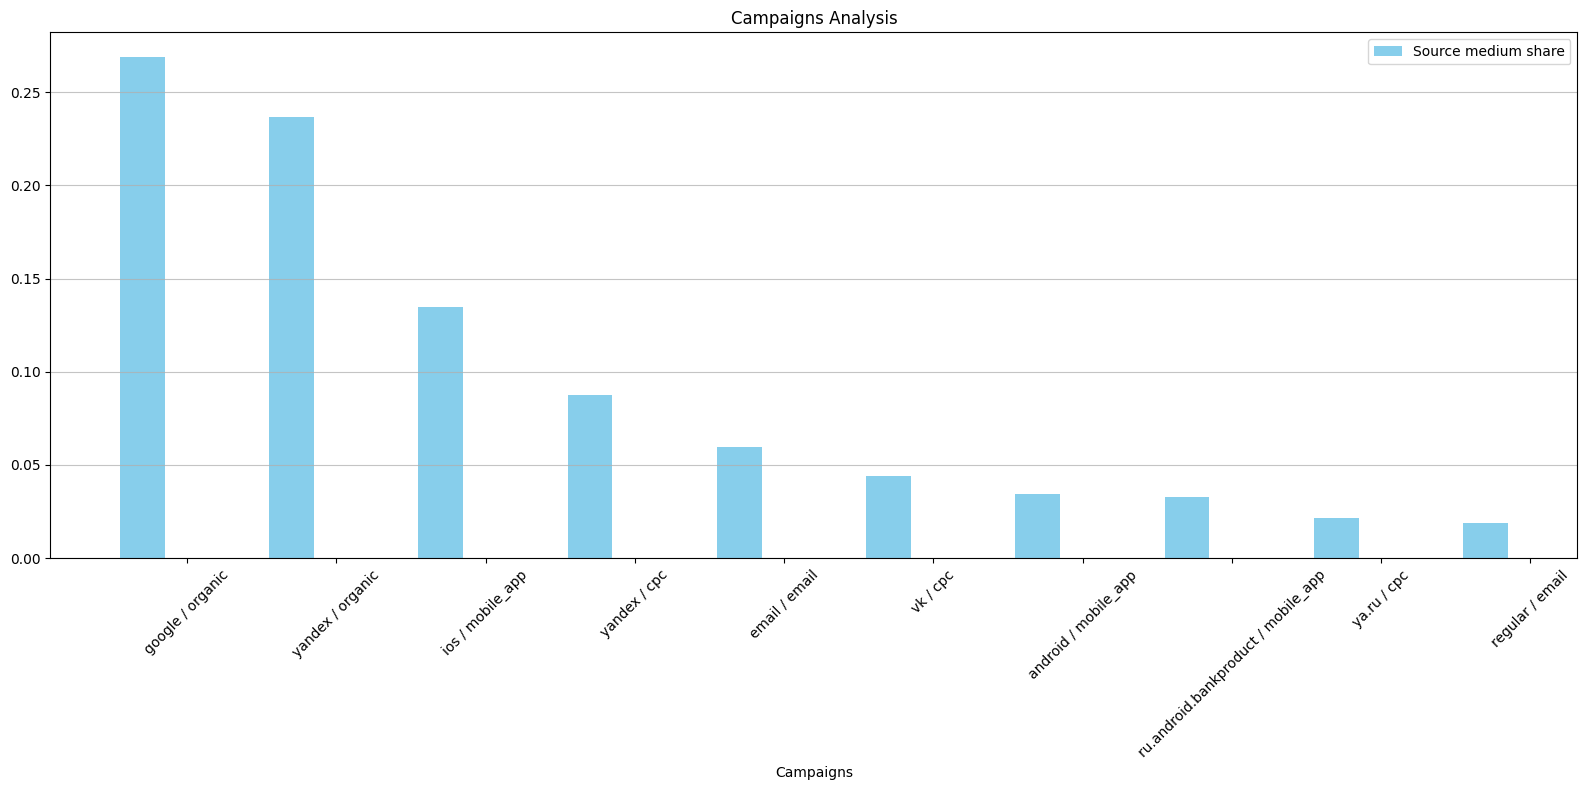

In [234]:
# Построение гистограммы для топ 10 кампаний
plt.figure(figsize=(16, 8))

bar_width = 0.3
index = range(len(campaigns_data))

# Первая система координат для гистограммы

plt.bar(index, campaigns_data['source_medium_score_share'], bar_width, label='Source medium share', color='skyblue')

    
plt.xlabel('Campaigns')
plt.title('Campaigns Analysis')
plt.xticks([i + bar_width for i in index], campaigns_data.index, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()


plt.show()

Ввиду особенностей базы представляется наиболее "справедливым" использование модели атрибуции по последнему касанию, поскольку она наиболее полно раскрывает эффективность конверсий при схожих общих результатах с линейной моделью атрибуции и невозможностью построения моделей по первому касанию и 40-20-40.